# Learning pipeline

**Author**: Miguel Xochicale [@mxochicale](https://github.com/mxochicale)     
**Contributors**: Nhat Phung Tran Huy [@huynhatd13](https://github.com/huynhatd13); Hamideh Kerdegari [@hamidehkerdegari](https://github.com/hamidehkerdegari);  Alberto Gomez [@gomezalberto](https://github.com/)  


## History
* Feb2022: Adding initial models with small dataset   
* March2022: Improved datasets representation
* April2022: Adds dataloader for clips and videos
* May2022: Tidies VGG2D and VGG3D   
* June2022: Tidies basicVGG model and adds heuristics for hyperarameters 
* Week1, July2022: Integreate modules in source path
* Week2, July2022: Implements Tromp2022Net DOI: https://doi.org/10.1016/S2589-7500(21)00235-17
* Week3, July2022: Adds LeNet, AlexNet and VGGNets, MobileNetV1, MobileNetV2


## Summary
This notebook presents a learning pipeline to classify 4 chamber view from echocardiography datasets.

### How to run the notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server  
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 
* https://nestedsoftware.com/2019/09/09/pytorch-image-recognition-with-convolutional-networks-4k17.159805.html 
* https://ai.stackexchange.com/questions/5769/in-a-cnn-does-each-new-filter-have-different-weights-for-each-input-channel-or
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 
* Kerdegari H. et al. 2021 https://github.com/vital-ultrasound/lung/tree/main/multiclass_tensorflow
* https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
* https://github.com/shanglianlm0525/PyTorch-Networks



# Jupyter Notebook

## 1. Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml
from pathlib import Path
import json
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from datetime import datetime


from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.helpers.various import concatenating_YAML_via_tags, \
                                    plot_dataset_classes, \
                                    split_train_validate_sets
from source.helpers.learning_pipeline import get_class_distribution, \
                                            plot_from_dict, \
                                            creating_pair_of_clips, \
                                            pair_clips_labels, \
                                            animate_clips
from source.models.learning_misc import train_loop, \
                                        test_loop, \
                                        basicVGG #, VGG3D
                                        
                

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

REPOSITORY_PATH='repositories/echocardiography'
FULL_REPO_PATH = HOME_PATH+'/'+REPOSITORY_PATH
FULL_REPO_MODEL_PATH = HOME_PATH +'/' + REPOSITORY_PATH + '/data/models'
CONFIG_FILES_PATH= REPOSITORY_PATH + '/scripts/config_files/users_paths_files'
YML_FILE =  'config_users_paths_files_username_' + USERNAME + '.yml'
FULL_PATH_FOR_YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, YML_FILE)
PATH_for_temporal_files = os.path.join(HOME_PATH, 'datasets/vital-us/echocardiography/temporal-files')

## Setting TRAINING_CURVES_PATH
#CURRENT_PATH=os.path.abspath(os.getcwd())
RESULTS_PATH='scripts/learning-pipeline/results'
TRAINING_CURVES_PATH = os.path.join(FULL_REPO_PATH, RESULTS_PATH)

## Setting FULL_PATH_FOR_YML_FILE
yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler
with open(FULL_PATH_FOR_YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)

## Printing Versions and paths
print(f'PyTorch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')    
print(f'FULL_PATH_FOR_YML_FILE: {FULL_PATH_FOR_YML_FILE}' )
print(f'FULL_REPO_MODEL_PATH: {FULL_REPO_MODEL_PATH}' )
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )


PyTorch Version: 1.9.0
Torchvision Version: 0.10.0a0
FULL_PATH_FOR_YML_FILE: /home/mx19/repositories/echocardiography/scripts/config_files/users_paths_files/config_users_paths_files_username_mx19.yml
FULL_REPO_MODEL_PATH: /home/mx19/repositories/echocardiography/data/models
TRAINING_CURVES_PATH: /home/mx19/repositories/echocardiography/scripts/learning-pipeline/results


## 2. Generate list text files for train and validate datasets

Edit config_users_paths_files_username_$USER.yml at '../config_files/users_paths_files/config_users_paths_files_username_template.yml' with the right paths and percentage of `ntraining`:  
```
#ECHODATASET_PATH = config['echodataset_path'] # Default
ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-GOOD'
TRAINING_SPLITTING = 0.8 #config['ntraining'] #Default
randomise_file_list: False
```

In [13]:
##############################
##### Setting up device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #or "cuda:NN" can also be used e.g., "cuda:0"
print(f'Device: {DEVICE}')


### Trump et al. 2022 
##"We trained the models on 55487 images from 1145 individual echocardiograms (appendix pp 2–3)." 
##Appendix pp 2–3.
##AC4: TRAINING: total videos 740 total frames 9615; T
##      TESTING: total videos:64 total frames 1218                


##############################
## Setting ECHODATASET_PATH; 
#ECHODATASET_PATH = config['echodataset_path'] # Default

#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-05-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 720,
    #"Test Dataset Size": 320,
    #"Validation Dataset Size": 280,

#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-10-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 1280,
    #"Test Dataset Size": 560,
    #"Validation Dataset Size": 440,

#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-20-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 2240,
    #"Test Dataset Size": 960,
    #"Validation Dataset Size": 720,

ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 3620,
    #"Test Dataset Size": 1540,
    #"Validation Dataset Size": 880,



#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-in-verification40-49'



TRAINING_SPLITTING = 0.80 #config['ntraining'] #Default
FLAG_RANDOMISE_DATA=True #config['randomise_file_list'] #Default

split_train_validate_sets(  
                        ECHODATASET_PATH, #config['echodataset_path']
                        config['data_list_output_path'], 
                        TRAINING_SPLITTING,
                        FLAG_RANDOMISE_DATA
                        )

# PRETRANSFORM_IM_SIZE = [64, 64] #[650, 690] original pixel size for VenueGO
PRETRANSFORM_IM_SIZE = [128, 128] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [256, 256] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [512, 512] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = config['pretransform_im_size'] ##DEFAULT

### >> CHANGE DENSE LAYER FEATURES IN VGG3D
### >> `self.fc0 = nn.Linear(in_features=4194304, out_features=500) #128x128`

##############################
##### Experiments for Basic HYPERPARAMETER Heuristics 

#### TESTS
NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 1; BATCH_SIZE_OF_CLIPS = 13; LEARNING_RATE= 0.00005; 


#################  LEARNING_RATE 
### EXPERIMENT 01,02,03,04
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 1; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.00005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.0000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.00000005; 

#################  BATCH_SIZE_OF_CLIPS with LEARNING_RATE= 0.000005 as it is the best peformance of prevous LRs 
### EXPERIMENT 04,06,07,08
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 2; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 5; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 15; LEARNING_RATE= 0.000005; 

#################  NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP with LEARNING_RATE= 0.000005 and BATCH_SIZE_OF_CLIPS=10
### EXPERIMENT 09,10,11,12
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 2; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 7; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 13; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 20; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 

##TOADD
### * NUMBER_OF_FRAMES_AND PARTICPANTS
### * OPTIMISERS 

# LEARNING_RATE =Trial and Error with diffent values  0.00005; 0.0005; 0.005 and 0.000001; 0.00001; 0.0001; 0.001  


MAX_EPOCHS = 500 #Alternatvely, make use of: config['max_epochs']


##############################
##### Setting up animation
interval_between_frames_in_milliseconds=33.3 ## 1/30=0.033333
frame_per_seconds_for_animated_frames=30


#SUBJECT_ID = '073'
#print(SUBJECT_ID)

### CUDA out of memory 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10
#PRETRANSFORM_IM_SIZE = [128, 128] 
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.05 GiB free; 8.53 GiB reserved in total by PyTorch)
## REBOOT MACHINE
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.13 GiB free; 8.53 GiB reserved in total by PyTorch)



##############################
## Setting labels
label_id = ('BKGR', '4CV')




Device: cuda
======= video_filenames: ('/01NVb-003-045/T2/01NVB-003-045-2 echo.mp4', '/01NVb-003-068/T3/01NVb-003-068-3 echo.mp4', '/01NVb-003-074/T1/01NVb-003-074-1 echo.mp4', '/01NVb-003-048/T3/01NVb-003-048-3 echo.mp4', '/01NVb-003-069/T2/01NVb-003-069-2 echo.mp4', '/01NVb-003-040/T1/01NVb-003-040-1 echo.mp4', '/01NVb-003-078/T1/01NVb-003-078-1 echo.mp4', '/01NVb-003-057/T3/01NVb-003-057-3 echo.mp4', '/01NVb-003-063/T1/01NVb-003-063-1 echo.mp4', '/01NVb-003-066/T2/01NVb-003-066-2 echo.mp4', '/01NVb-003-045/T3/01NVb-003-045-3 echo.mp4', '/01NVb-003-047/T1/01NVb-003-047-1 echo.mp4', '/01NVb-003-071/T3/01NVb-003-071-3 echo.mp4', '/01NVb-003-043/T1/01NVb-003-043-2 echo.mp4', '/01NVb-003-075/T1/01NVb-003-075-1 echo.mp4', '/01NVb-003-071/T2/01NVb-003-071-2 echo.mp4', '/01NVb-003-047/T3/01NVb-003-047-3 echo.mp4', '/01NVb-003-076/T3/01NVb-003-076-3 echo.mp4', '/01NVb-003-054/T1/01NVb-003-054-1 echo.mp4', '/01NVb-003-043/T1/01NVb-003-043-1 echo.mp4', '/01NVb-003-041/T1/01NVb-003-041-1 echo.m

## 2. Setting variables and loading datasets using pytorch dataloader

In [3]:
# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=PRETRANSFORM_IM_SIZE),
        transforms.ToTensor(),
    ])
else:
    pretransform = None
    
    #config['use_train_augmentation']#Default
    
# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        #transforms.RandomRotation(degrees=2),  # in degrees
        #transforms.RandomEqualize(p=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


train_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    #transform=None,#transform=train_transform,
    transform=train_transform,
    use_tmp_storage=config['use_tmp_storage']
    )

validation_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=None,#transform=train_transform,
    use_tmp_storage=config['use_tmp_storage']
    )


## Spliting train_dataset into train_set and test_set
Ntdt = train_dataset.__len__()
ntraining = 0.7

Ntrain=round(Ntdt*ntraining)
Ntest = round(Ntdt - (Ntdt*ntraining))
print(f'Ntrain size: {Ntrain}, Ntest size: {Ntest}, "Ntrain+Ntest" size={Ntrain+Ntest}')
train_set, test_set = torch.utils.data.random_split(train_dataset, [Ntrain, Ntest])


[ERROR] [EchoClassesDataset.__init__()] Error reading /media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects//01NVb-003-074/T3/01NVb-003-074-3-4CV.json (empty). Removing from list
Ntrain size: 174, Ntest size: 74, "Ntrain+Ntest" size=248


## 3. Plotting Class Distribution (creates temp clips and it takes few minutes)

[INFO] [EchoClassesDataset.__getitem__()] - computing clips and saving to temporary folder /home/mx19/datasets/vital-us/echocardiography/temporal-files/echovideodatafiles_FRAMESPERCLIP1_PIXELSIZE_128W128H
class_distribution(train_set): {'BKGR': 87, '4CV': 87}
class_distribution(validation_dataset): {'BKGR': 27, '4CV': 27}
class_distribution(test_set): {'BKGR': 37, '4CV': 37}
Number of frames for training datasets 174
Number of frames for Validation datasets 54
Number of frames for testing datasets 74


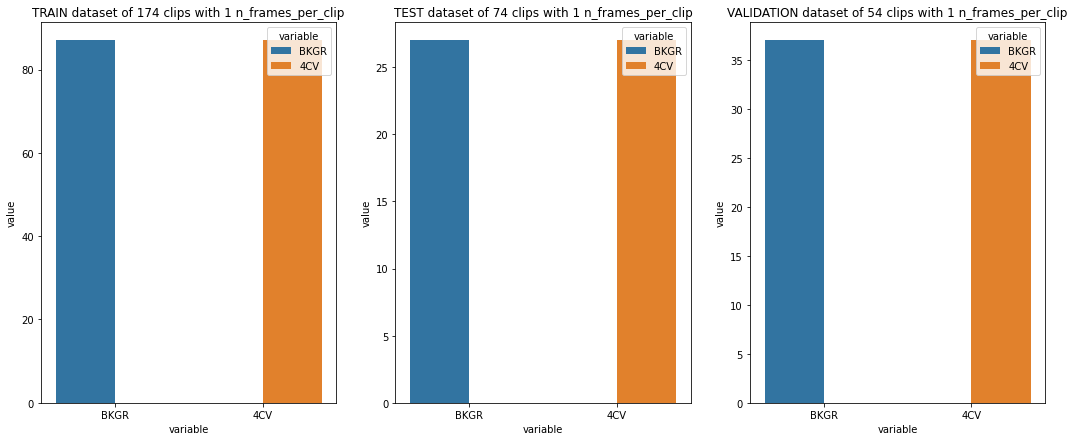

In [4]:
train_set_class_dict = get_class_distribution(train_set,label_id)
val_set_class_dict = get_class_distribution(validation_dataset,label_id)
test_set_class_dict = get_class_distribution(test_set,label_id)

print(f'class_distribution(train_set): {train_set_class_dict}')
print(f'class_distribution(validation_dataset): {val_set_class_dict}' )
print(f'class_distribution(test_set): {test_set_class_dict}')
    
#number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip']    
print(f'Number of frames for training datasets {len(train_set)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')
print(f'Number of frames for Validation datasets {len(validation_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')
print(f'Number of frames for testing datasets {len(test_set)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')

plot_title_train_label= f'TRAIN dataset of {len(train_set)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_val_label= f'VALIDATION dataset of {len(validation_dataset)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_test_label= f'TEST dataset of {len(test_set)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
plot_from_dict(train_set_class_dict, plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(val_set_class_dict, plot_title=plot_title_test_label, ax=axes[1])
plot_from_dict(test_set_class_dict, plot_title=plot_title_val_label, ax=axes[2])
plt.show()



## 4. Animating frames of one clip of the dataloader

In [5]:
print(f'---------------------------------------')
clips=creating_pair_of_clips(train_dataset, label_id)
pair_clips_and_labels = pair_clips_labels(clips)


---------------------------------------
 CLIP:00 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 31
 CLIP:01 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 92
 CLIP:02 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 152 from clip_frame_clip_idx 22
 CLIP:03 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 36
 CLIP:04 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 97
 CLIP:05 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 69 from clip_frame_clip_idx 6
 CLIP:06 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 152 from clip_frame_clip_idx 109
 CLIP:07 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 51 from clip_frame_clip_idx 3
 CLIP:08 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 61
 CLIP:09 of BKGR label for torch.Size([1, 1, 

 CLIP:112 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 39
 CLIP:113 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 66
 CLIP:114 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 39 from clip_frame_clip_idx 1
 CLIP:115 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 135
 CLIP:116 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 107
 CLIP:117 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 108
 CLIP:118 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 31 from clip_frame_clip_idx 22
 CLIP:119 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 67
 CLIP:120 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 8
 CLIP:121 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151

 CLIP:229 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 579 from clip_frame_clip_idx 551
 CLIP:230 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 338 from clip_frame_clip_idx 87
 CLIP:231 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 137 from clip_frame_clip_idx 104
 CLIP:232 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 161 from clip_frame_clip_idx 92
 CLIP:233 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 135 from clip_frame_clip_idx 53
 CLIP:234 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 113 from clip_frame_clip_idx 87
 CLIP:235 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 139 from clip_frame_clip_idx 88
 CLIP:236 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 127 from clip_frame_clip_idx 67
 CLIP:237 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 99 from clip_frame_clip_idx 28
 CLIP:238 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 58 from cli

<Figure size 432x288 with 0 Axes>

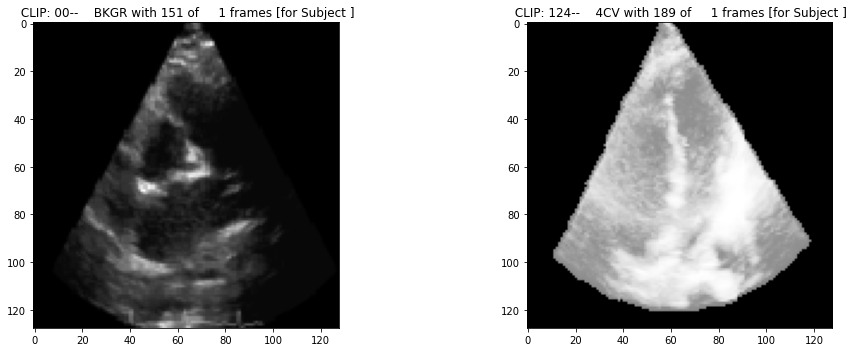

In [6]:
#average_HR =
#fps = 30
# 60 # beats per minute
#Beats-per-minute: 60 BPM
#Beats-per-second: 1 Hz
#Cycle-per-second: 1 (Cycle/s)

PAIR_OF_CLIPS = pair_clips_and_labels[0]

animated_frames=animate_clips(PAIR_OF_CLIPS, label_id, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP,
                  interval_between_frames_in_milliseconds)
HTML(animated_frames.to_jshtml())      


# ##SAVE ANIMATIONS
# for idx in range(0,len(pair_clips_labels)):
#     PAIR_OF_CLIPS = pair_clips_labels[idx]
#     print( f' pair_clips_labels {str(PAIR_OF_CLIPS[2])} {str(PAIR_OF_CLIPS[6])}')
    

## 5. Displayting frames in the dataloader

In [7]:

print(f'====================================================')
print(f'train_dataset.__len__() = {train_set.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True,
    num_workers=0)


print(f'====================================================')
print(f'len(train_dataloader): {len(train_dataloader)} BATCHES of BATCH_SIZE_OF_CLIPS {BATCH_SIZE_OF_CLIPS}')
for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'  ====================================================')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'    BATCH_OF_CLIPS_INDEX : {clip_batch_idx} / {len(train_dataloader) - 1}')
    print(f'    sample_batched_labels.size(): {  sample_batched_labels.size()  }')
    print(f'    sample_batched_labels.squeeze().size(): {  sample_batched_labels.squeeze().size()  }')
    print(f'    sample_batched_images.size(): {sample_batched_images.size()}')

    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(f'        BATCH_SIZE_IDX {BATCH_SIZE_IDX} ')
        print(f'          label: {label}')
        sample_batched_idx_image = sample_batched_images[BATCH_SIZE_IDX,...]
        print(f'          Sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )

        grid = utils.make_grid(sample_batched_idx_image)
        print(f'          Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()


print(f'====================================================')
print(f' test_dataset.__len__() = {test_set.__len__()}')
test_dataloader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f'====================================================')
print(f' validation_dataset.__len__() = {validation_dataset.__len__()}')
val_dataloader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

train_dataset.__len__() = 174
len(train_dataloader): 14 BATCHES of BATCH_SIZE_OF_CLIPS 13
    BATCH_OF_CLIPS_INDEX : 0 / 13
    sample_batched_labels.size(): torch.Size([13])
    sample_batched_labels.squeeze().size(): torch.Size([13])
    sample_batched_images.size(): torch.Size([13, 1, 1, 128, 128])
        BATCH_SIZE_IDX 0 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 1 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 2 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 3 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 4 
          label: 0


    BATCH_OF_CLIPS_INDEX : 6 / 13
    sample_batched_labels.size(): torch.Size([13])
    sample_batched_labels.squeeze().size(): torch.Size([13])
    sample_batched_images.size(): torch.Size([13, 1, 1, 128, 128])
        BATCH_SIZE_IDX 0 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 1 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 2 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 3 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 4 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid siz

## 7. Define networks
See `$HOMErepositories/echocardiography/source/models/learning_misc.py` to amend or implement other models

In [8]:
# ######################################
# ##### Define TrompNet2022 architecture
# class TrompNet2022(nn.Module):

#     def __init__(self, input_pixel_size, n_batch_size_of_clips, n_frames_per_clip, n_classes=2):
#         """
#         Simple Video classifier by Tromp et al. 2022. DOI https://doi.org/10.1016/S2589-7500(21)00235-1
        
        
#         The first classifier was a supervised CNN, composed of 
#             * four convolutional layers, 
#             * a dense layer, and 
#             * a softmax output layer. 
#         This model was trained with a categorical cross-entropy loss function.
        
#         Args:
#             input_pixel_size:  shape of the input image. Should be a 2 element vector for a 2D video (width, height) [e.g. 128, 128].
#             n_batch_size_of_clips: (self explanatory)
#             n_frames_per_clip: (self explanatory)
#             n_classes: number of output classes
#         """
        
        
#         super(TrompNet2022, self).__init__()
#         self.name = 'tromp2022Net'
        
#         self.input_pixel_size = input_pixel_size #[128, 128]
#         self.n_batch_size_of_clips = n_batch_size_of_clips  #BATCH_SIZE_OF_CLIPS
#         self.n_frames_per_clip = n_frames_per_clip #NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP
#         self.n_classes = n_classes
#         #print(f'self.n_frames_per_clip {self.n_frames_per_clip}')
#         self.n_features = np.prod(self.input_pixel_size) * self.n_frames_per_clip
        

#         #self.n_batch_size_of_clips    
#         self.conv0 = nn.Conv2d(in_channels=1, 
#                                out_channels=64,
#                                kernel_size=(3, 3), 
#                                stride=(1, 1), #H_{in}/strideA, W_{in}/strideB
#                                padding = (0, 0), 
#                                #dilation=(0, 0)
#                               )
#         #Input: (N,Cin,Hin,Win)(N, C_{in}, H_{in}, W_{in})
#         #Output: (N,Cout,Hout,Wout)(N, C_{out}, H_{out}, W_{out})
#         #N is a batch size

#         self.conv1 = nn.Conv2d(in_channels=64, 
#                        out_channels=128,
#                        kernel_size=(3, 3), 
#                        stride=(1, 1), #H_{in}/strideA, W_{in}/strideB
#                        padding = (0, 0), 
#                        #dilation=(0, 0)
#                       )

        
#         self.conv2 = nn.Conv2d(in_channels=128, 
#                        out_channels=32,
#                        kernel_size=(3, 3), 
#                        stride=(1, 1), #H_{in}/strideA, W_{in}/strideB
#                        padding = (0, 0), 
#                        #dilation=(0, 0)
#                       )        
        
#         self.conv3 = nn.Conv2d(in_channels=32, 
#                        out_channels=10,
#                        kernel_size=(3, 3), 
#                        stride=(1, 1), #H_{in}/strideA, W_{in}/strideB
#                        padding = (0, 0), 
#                        #dilation=(0, 0)
#                       )
                
        
#         self.flatten = nn.Flatten()
#         #self.relu = nn.ReLU()
#         #self.sigmoid = nn.Sigmoid()

#         self.fc0 = nn.Linear(in_features=144000, out_features=self.n_classes)

#         ### Softmax
#         #self.softmax = nn.Softmax() # UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
#         #self.softmax = nn.Softmax(dim=0) #along row
#         self.softmax = nn.Softmax(dim=1) #along the column (for linear output)
#         #https://discuss.pytorch.org/t/implicit-dimension-choice-for-softmax-warning/12314/12
        

        
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # print(f'x.shape(): {x.size()}') ##[batch_size, channels, depth, height, width]
#         # x = x.permute(0,2,1,3,4)##[batch_size, depth, channels, height, width]
#         #print(f'x.shape(): {x.size()}') # torch.Size([20, 1, 1, 128, 128]) 
#         x = torch.squeeze(x,dim=1)
#         #x = torch.unsqueeze(x,dim=1)
#         #print(f'x.shape(): {x.size()}') # torch.Size([20, 1, 128, 128])
        
#         #print(f'X.shape(): {x.size()}')
#         x = self.conv0(x)
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         #print(f'conv3(x): {x.size()}')
        

#         x = self.flatten(x)
#         #print(f'self.flatten(x) size() {x.size()}')  # x.shape(): torch.Size([4, 983040])
#         x = self.fc0(x)
#         #print(f'fc0(): {x.size()}')
        
#         x = self.softmax(x)
#         #print(f'x.shape(): {x.size()}')

#         return x

# ######################################
# ##### LeNet5 https://medium.datadriveninvestor.com/cnn-architectures-from-scratch-c04d66ac20c2
# class LeNet5(nn.Module):
#     def __init__(self, n_classes=2):
        
#         super(LeNet5, self).__init__()
#         self.name = 'LeNet5'
        
#         self.tanh = nn.Tanh()      
#         self.pool = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
#         self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(5,5),stride=(1,1))
#         self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5),stride=(1,1))
#         self.conv3 = nn.Conv2d(in_channels=16,out_channels=120,kernel_size=(5,5),stride=(1,1))
#         self.flatten = nn.Flatten()
#         self.linear1 = nn.Linear(75000, 84)
#         self.linear2 = nn.Linear(84, n_classes)

#     def forward(self,x):
#         x = torch.squeeze(x,dim=1)
#         x = self.tanh(self.conv1(x))
#         x = self.pool(x)
#         x = self.tanh(self.conv2(x))
#         x = self.pool(x)
#         x = self.tanh(self.conv3(x))
#         #print(f'x.shape(): {x.size()}') 
#         #x = x.reshape(x.shape[0],-1) #75000
#         x = self.flatten(x)
# #         print(f'x.shape(): {x.size()}') 
#         x = self.tanh(self.linear1(x))
#         x = self.linear2(x)
#         return x    




# ######################################
# ##### LeNet5 https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/
# class LeNet5(nn.Module):
#     def __init__(self, n_classes=2):
        
#         super(LeNet5, self).__init__()
#         self.name = 'LeNet5'
        
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
#             nn.BatchNorm2d(6),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.fc = nn.Linear(13456, 120)
#         self.relu = nn.ReLU()
#         self.fc1 = nn.Linear(120, 84)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(84, n_classes)
    
#     def forward(self,x):
#         x = torch.squeeze(x,dim=1)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = x.reshape(x.size(0), -1)
#         x = self.fc(x)
#         x = self.relu(x)
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.fc2(x)
        
#         return x    



# #https://github.com/lychengr3x/LeNet-5-Implementation-Using-Pytorch/blob/master/LeNet-5%20Implementation%20Using%20Pytorch.ipynb
# class LeNet5(nn.Module):

#     # network structure
#     def __init__(self, n_classes=2):
        
#         super(LeNet5, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         #self.fc1   = nn.Linear(16*5*5, 120)
#         self.fc1   = nn.Linear(14400, 120)
#         self.fc2   = nn.Linear(120, 84)
#         self.fc3   = nn.Linear(84, n_classes)
#         self.flatten = nn.Flatten()
        
#     def forward(self, x):
#         '''
#         One forward pass through the network.
        
#         Args:
#             x: input
#         '''
#         x = torch.squeeze(x,dim=1)
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
#         #x = x.view(-1, self.num_flat_features(x))
#         #x = x.reshape(x.size(0), -1)
#         x = self.flatten(x)
#         #print(f'x.shape(): {x.size()}') 
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# ##     def num_flat_features(self, x):
# ##         '''
# ##         Get the number of features in a batch of tensors `x`.
# ##         '''
# ##         size = x.size()[1:]
# ##         return np.prod(size)



# class AlexNet(nn.Module):
#     def __init__(self, n_classes=2):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(),
#             nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(),
#             nn.Linear(4096, n_classes),
#         )
        
#     def forward(self, x):
#         x = torch.squeeze(x,dim=1)
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x


# #https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py    
# class AlexNet(nn.Module):
#     def __init__(self, n_classes=2):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
# #             nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(p=0.5),
#             nn.Linear(256 * 6 * 6, 4096),
#             #nn.Linear(9216, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, n_classes),
#         )
        
#     def forward(self, x):
#         x = torch.squeeze(x,dim=1)
#         #print(f'x.shape(): {x.size()}') 
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         #print(f'x.shape(): {x.size()}') 
#         x = self.classifier(x)
#         return x
    
    
# ##https://blog.paperspace.com/alexnet-pytorch/    
# # WORKING OK
# class AlexNet(nn.Module):
#     def __init__(self, n_classes=2):
#         super(AlexNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=0),
#             nn.BatchNorm2d(96),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.fc = nn.Sequential(
#             nn.Dropout(0.5),
#             #nn.Linear(9216, 4096),            
#             nn.Linear(1024, 4096),
#             nn.ReLU())
#         self.fc1 = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU())
#         self.fc2= nn.Sequential(
#             nn.Linear(4096, n_classes))
        
#     def forward(self, x):
#         x = torch.squeeze(x,dim=1)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = x.reshape(x.size(0), -1)
#         #print(f'x.shape(): {x.size()}')
#         #x = torch.flatten(x, 1)
#         x = self.fc(x)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return x 


# #https://developpaper.com/example-of-pytorch-implementing-alexnet/
# class AlexNet(nn.Module):
#   def __init__(self,n_classes=2):
#     super(AlexNet,self).__init__()
#     self.feature_extraction = nn.Sequential(
#       nn.Conv2d(in_channels=1,out_channels=96,kernel_size=11,stride=4,padding=2,bias=False),
#       nn.ReLU(inplace=True),
#       nn.MaxPool2d(kernel_size=3,stride=2,padding=0),
#       nn.Conv2d(in_channels=96,out_channels=192,kernel_size=5,stride=1,padding=2,bias=False),
#       nn.ReLU(inplace=True),
#       nn.MaxPool2d(kernel_size=3,stride=2,padding=0),
#       nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1,padding=1,bias=False),
#       nn.ReLU(inplace=True),
#       nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
#       nn.ReLU(inplace=True),
#       nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
#       nn.ReLU(inplace=True),
#       nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
#     )
#     self.classifier = nn.Sequential(
#       nn.Dropout(p=0.5),
#       #nn.Linear(in_features=256*6*6,out_features=4096),
#       nn.Linear(in_features=2304,out_features=4096),
#       nn.ReLU(inplace=True),
#       nn.Dropout(p=0.5),
#       nn.Linear(in_features=4096, out_features=4096),
#       nn.ReLU(inplace=True),
#       nn.Linear(in_features=4096, out_features=n_classes),
#     )
#   def forward(self,x):
#     x = torch.squeeze(x,dim=1)
#     x = self.feature_extraction(x)
#     #print(f'x.shape(): {x.size()}')
#     #x = x.view(x.size(0),256*6*6)
#     x = torch.flatten(x, 1)
#     #print(f'x.shape(): {x.size()}')
#     x = self.classifier(x)
#     return x


# #https://github.com/jmjeon94/MobileNet-Pytorch/blob/master/MobileNetV1.py
# #https://towardsdatascience.com/review-mobilenetv1-depthwise-separable-convolution-light-weight-model-a382df364b69
# class MobileNetV1(nn.Module):
#     def __init__(self, ch_in, n_classes):
#         super(MobileNetV1, self).__init__()

#         def conv_bn(inp, oup, stride):
#             return nn.Sequential(
#                 nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
#                 nn.BatchNorm2d(oup),
#                 nn.ReLU(inplace=True)
#                 )

#         def conv_dw(inp, oup, stride):
#             return nn.Sequential(
#                 # dw: depthwise convolution 
#                 nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
#                 nn.BatchNorm2d(inp),
#                 nn.ReLU(inplace=True),

#                 # pw: pointwise convolution
#                 nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
#                 nn.BatchNorm2d(oup),
#                 nn.ReLU(inplace=True),
#                 )

#         self.model = nn.Sequential(
#             conv_bn(ch_in, 32, 2),
#             conv_dw(32, 64, 1),
#             conv_dw(64, 128, 2),
#             conv_dw(128, 128, 1),
#             conv_dw(128, 256, 2),
#             conv_dw(256, 256, 1),
#             conv_dw(256, 512, 2),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 1024, 2),
#             conv_dw(1024, 1024, 1),
#             nn.AdaptiveAvgPool2d(1)
#         )
#         self.fc = nn.Linear(1024, n_classes)

#     def forward(self, x):
#         x = torch.squeeze(x,dim=1)
#         x = self.model(x)
#         x = x.view(-1, 1024)
#         x = self.fc(x)
#         return x


############################################################################
## https://github.com/jmjeon94/MobileNet-Pytorch/blob/master/MobileNetV2.py
## MobileNetV2: Inverted Residuals and Linear Bottlenecks
## https://arxiv.org/abs/1801.04381
def dwise_conv(ch_in, stride=1):
    return (
        nn.Sequential(
            #depthwise
            nn.Conv2d(ch_in, ch_in, kernel_size=3, padding=1, stride=stride, groups=ch_in, bias=False),
            nn.BatchNorm2d(ch_in),
            nn.ReLU6(inplace=True),
        )
    )

def conv1x1(ch_in, ch_out):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

def conv3x3(ch_in, ch_out, stride):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

class InvertedBlock(nn.Module):
    def __init__(self, ch_in, ch_out, expand_ratio, stride):
        super(InvertedBlock, self).__init__()

        self.stride = stride
        assert stride in [1,2]

        hidden_dim = ch_in * expand_ratio

        self.use_res_connect = self.stride==1 and ch_in==ch_out

        layers = []
        if expand_ratio != 1:
            layers.append(conv1x1(ch_in, hidden_dim))
        layers.extend([
            #dw
            dwise_conv(hidden_dim, stride=stride),
            #pw
            conv1x1(hidden_dim, ch_out)
        ])

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.layers(x)
        else:
            return self.layers(x)

class MobileNetV2(nn.Module):
    def __init__(self, ch_in=3, n_classes=1000):
        super(MobileNetV2, self).__init__()

        self.configs=[
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]

        self.stem_conv = conv3x3(ch_in, 32, stride=2)

        layers = []
        input_channel = 32
        for t, c, n, s in self.configs:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedBlock(ch_in=input_channel, ch_out=c, expand_ratio=t, stride=stride))
                input_channel = c

        self.layers = nn.Sequential(*layers)

        self.last_conv = conv1x1(input_channel, 1280)

        self.classifier = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(1280, n_classes)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = torch.squeeze(x, dim=1)
        x = self.stem_conv(x)
        x = self.layers(x)
        x = self.last_conv(x)
        x = self.avg_pool(x).view(-1, 1280)
        x = self.classifier(x)
        return x



## 8. Sanity checks for the model and dataloaders

In [9]:
##################################################################
##################################################################
##################################################################

##################################################################
##################################################################
##################################################################
##### Tensor Shape
#tensor_shape_size = [BATCH_SIZE_OF_CLIPS, config['number_of_frames_per_segment_in_a_clip'], 1, 128, 128]
#model = basicVGGNet(tensor_shape_size)

#n_frames_per_clip 
#model = VGG3D(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#model = basicVGG(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #torch.Size([BATCH_SIZE_OF_CLIPS, CLASS_NUMBER])
#model = TrompNet2022(PRETRANSFORM_IM_SIZE, BATCH_SIZE_OF_CLIPS, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#model = LeNet5()
#model = AlexNet()
#model=MobileNetV1(ch_in=1, n_classes=2)
model=MobileNetV2(ch_in=1, n_classes=2)

model.to(DEVICE) # Place model on GPU

print(model) 
#print(str(summary(model, (1, 32, 32), depth=1)))

### Sanity check
#print(len(train_dataloader)) #6 BATCHES of 10=BATCH_SIZE_OF_CLIPS
sample_batched = next(iter(train_dataloader))
#print(sample_batched[0].shape) #torch.Size([10, 60, 1, 128, 128])
#print(sample_batched[1])#tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1])
#print(sample_batched[2]) #tensor([47, 42,  0, 51, 49, 75, 67, 67, 62, 84])
#print(sample_batched[3]) #tensor([105, 102,  43, 106,  94, 161, 151, 183, 150, 151])

clip_batch = sample_batched[0]
#print(f'clip_batch.size() {clip_batch.size()}') ##torch.Size([4, 60, 1, 128, 128])
#                                                ##[batch_size, channels, depth, height, width]

# # frames = image.to(device)
print(model(clip_batch).shape) #torch.Size([4, 2])
print(  type(model(clip_batch))  )  #torch.Size([4, 2]) #<class 'torch.Tensor'>

# #https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch
del sample_batched
torch.cuda.empty_cache()

MobileNetV2(
  (stem_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (layers): Sequential(
    (0): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
      )
    )
    (1): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fals

torch.Size([13, 2])
<class 'torch.Tensor'>


## 8. Define Optimizer
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
3. Set the number of clips per batch

In [10]:
#model = VGG3D(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#model = basicVGG(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #torch.Size([BATCH_SIZE_OF_CLIPS, CLASS_NUMBER])
#model = TrompNet2022(PRETRANSFORM_IM_SIZE, BATCH_SIZE_OF_CLIPS, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


# ##############
# #### LeNet5
# model = LeNet5()
# gamma=.001 #LetNet_5()
# rho=.9 #LetNet_5()
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho) #LeNet5

##############
# #### AlexNet
# model = AlexNet()
# #gamma=0.005#AlexNet
# gamma=0.001#AlexNet
# pshi=0.005#AlexNet
# rho=0.9#AlexNet
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, weight_decay = pshi, momentum = rho)  #AlexNet

##############
# #### MobileNetV1
# #https://docs.netspresso.ai/docs/classification-mobilenet-v1-on-cifar100
# model=MobileNetV1(ch_in=1, n_classes=2)
# gamma=0.1
# #pshi=0.005
# rho=0.9
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum = rho) 



#### MobileNetV2
model=MobileNetV2(ch_in=1, n_classes=2)
gamma=0.01
#pshi=0.005
rho=0.9
model.to(DEVICE) # Place model on GPU
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum = rho) 

# A Flower Classification Approach with MobileNetV2 and Transfer Learning (2020)
#   https://isciia2020.bit.edu.cn/docs/20201114083020836285.pdf                  


# #############
# #### MobileNetV2
# #MobileNetV2: Inverted Residuals and Linear Bottlenecks: paper: https://arxiv.org/abs/1801.04381
# model=MobileNetV2(ch_in=1, n_classes=2)
# rho=0.045 #Learning rate
# mu=0.9 # momentum
# lambda_ = 0.00004 # weight decay
# #learning rate decay rate of 0.98 per epoch?
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.RMSprop(model.parameters(), lr=rho, momentum = mu, weight_decay=lambda_) 
# # https://arxiv.org/pdf/1801.04381.pdf
# # https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html 



# #https://github.com/d-li14/mobilenetv2.pytorch/issues/2#issuecomment-454282418
#torch.optim.SGD                    


# rho=0.001 #Learning rate #https://www.kaggle.com/code/gpiosenka/mobilenet-v2-transfer-learning-99-accuracy/notebook
# optimizer = torch.optim.Adam(lr=rho)


                    





## PRINT MODEL
print(f'====================================================')
print(model)

# ### PRINT model.named_parameters
# print(f'====================================================')
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)



MobileNetV2(
  (stem_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (layers): Sequential(
    (0): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
      )
    )
    (1): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fals

## 9. Training loop

In [11]:
### TRAINING
#clip_batch_size = tuple(train_dataloader.dataset.__getitem__(0)[0].shape) ##(60, 1, 128, 128) frames, chs, [width, height]
#print(clip_batch_size)


startt = time.time()
print(f'Starting training loop {startt}')


############################
####### BINARY ACCURACY MODULE
def binary_accuracy(y_pred, y_test):
    """
    binary_accuracy to calculate accuracy per epoch.
    """
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    accuracy = correct_results_sum/y_test.shape[0]
    accuracy = torch.round(accuracy * 100)
    return accuracy


############################
####### TRAIN LOOP MODULE
def train_loop(train_dataloader, model, criterion, optimizer, device):
    """
    train_loop
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        train_epoch_loss
    """
    train_epoch_loss = 0
    train_acc_loss_epoch = 0
    step_train = 0
    #size = len(train_dataloader.dataset)
    for clip_batch_idx, sample_batched in enumerate(train_dataloader):
        step_train += 1
        X_train_batch, y_train_batch = sample_batched[0].to(device), sample_batched[1].to(device)

        #print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        # print(f'----------------------------------------------------------')
        # print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        # print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        # Compute prediction and loss
        y_train_pred = model(X_train_batch) #torch.Size([9, 2])
        #y_train_pred = model(X_train_batch).squeeze()  # torch.Size([9, 2])
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_accuracy(y_train_pred, y_train_batch)

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # if clip_batch_idx % 10 == 0: ## Print loss values every 10 clip batches
        #     train_loss, current = train_loss.item(), clip_batch_idx * len(X_train_batch)
        #     print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

        train_epoch_loss += train_loss.detach().item()
        train_acc_loss_epoch += train_acc.detach().item()

    train_epoch_loss /= step_train
    train_acc_loss_epoch /= step_train

    return train_epoch_loss, train_acc_loss_epoch


############################
####### TEST LOOP MODULE
def test_loop(dataloader, model, criterion, device):
    """
    Test loop 
    
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        test_epoch_loss, correct
    """

    train_epoch_acc = 0
    step_test = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_epoch_loss, correct = 0, 0

    with torch.no_grad():
        #model.eval()
        #val_epoch_loss = 0
        #val_epoch_acc = 0
        for clip_batch_idx, sample_val_batched in enumerate(dataloader):
            step_test += 1
            X_val_batch, y_val_batch = sample_val_batched[0].to(device), sample_val_batched[1].to(device)
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            test_epoch_loss += criterion(y_val_pred, y_val_batch).detach().item()
            correct += (y_val_pred.argmax(1) == y_val_batch).type(torch.float).sum().detach().item()

    test_epoch_loss /= num_batches
    correct /= size

    return test_epoch_loss, correct


#Dictionaries to store the accuracy/epoch and loss/epoch for both train and validation sets.
loss_stats = {
    'train': [],
    'test': [],
    #"val": []
}
accuracy_stats = {
    'train': [],
    'test': [],
    #"val": []
}

#for epoch in tqdm(range(1, MAX_EPOCHS)):   
for epoch in range(MAX_EPOCHS):
    print("-" * 10)
    print(f"EPOCH {epoch + 1}/{MAX_EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    
    
    train_epoch_loss, train_acc_loss_epoch = train_loop(train_dataloader, model, criterion, optimizer, DEVICE)
    
    
    model.eval()
    test_epoch_loss, correct = test_loop(val_dataloader, model, criterion, DEVICE)

    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} | Average Train Acc: {train_epoch_acc:.5f} | Average Validation Loss: {val_epoch_loss:.3f} | Average Validation Acc: {val_epoch_acc:.5f} ')
    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} |Average Train Acc: {train_epoch_acc:.5f}  ')
    
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_epoch_loss:>8f} \n")

    print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} Average Train Accuracy Loss: {(train_acc_loss_epoch):>0.1f}% ')
    
    print(f"Test Error: \n Test Accuracy: {(100*correct):>0.1f}%, Avg Test loss: {test_epoch_loss:>8f} \n")
    
    
    loss_stats['train'].append(train_epoch_loss)
    loss_stats['test'].append(test_epoch_loss)
    accuracy_stats['train'].append(train_acc_loss_epoch)
    accuracy_stats['test'].append(100*correct)
            
print("DONE TRAINING LOOP!")



endt = time.time()
elapsed_time = endt - startt
print(f'Finishing training loop {endt}')
print(f'Elapsed time for the training loop: {elapsed_time} (s)')

#model_path = ' /home/mx19/repositories/echocardiography/models' 
print(f' {FULL_REPO_MODEL_PATH}')
torch.save(model.state_dict(), os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth"))
print("Saved metric model")

print(loss_stats)
print(accuracy_stats)


Starting training loop 1658428973.3565457
----------
EPOCH 1/500
Epoch 00: | Average Train Loss: 0.867 Average Train Accuracy Loss: 47.6% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.720942 

----------
EPOCH 2/500
Epoch 01: | Average Train Loss: 1.013 Average Train Accuracy Loss: 51.8% 
Test Error: 
 Test Accuracy: 53.7%, Avg Test loss: 0.762641 

----------
EPOCH 3/500
Epoch 02: | Average Train Loss: 0.885 Average Train Accuracy Loss: 52.0% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 4.878350 

----------
EPOCH 4/500
Epoch 03: | Average Train Loss: 1.334 Average Train Accuracy Loss: 46.2% 
Test Error: 
 Test Accuracy: 57.4%, Avg Test loss: 1.077772 

----------
EPOCH 5/500
Epoch 04: | Average Train Loss: 1.288 Average Train Accuracy Loss: 45.9% 
Test Error: 
 Test Accuracy: 44.4%, Avg Test loss: 1.108520 

----------
EPOCH 6/500
Epoch 05: | Average Train Loss: 1.154 Average Train Accuracy Loss: 54.6% 
Test Error: 
 Test Accuracy: 48.1%, Avg Test loss: 1.138878 

----

Epoch 51: | Average Train Loss: 0.639 Average Train Accuracy Loss: 72.1% 
Test Error: 
 Test Accuracy: 68.5%, Avg Test loss: 0.793732 

----------
EPOCH 53/500
Epoch 52: | Average Train Loss: 0.649 Average Train Accuracy Loss: 76.2% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 1.290756 

----------
EPOCH 54/500
Epoch 53: | Average Train Loss: 0.549 Average Train Accuracy Loss: 73.0% 
Test Error: 
 Test Accuracy: 75.9%, Avg Test loss: 0.456442 

----------
EPOCH 55/500
Epoch 54: | Average Train Loss: 0.546 Average Train Accuracy Loss: 72.6% 
Test Error: 
 Test Accuracy: 68.5%, Avg Test loss: 0.854624 

----------
EPOCH 56/500
Epoch 55: | Average Train Loss: 0.616 Average Train Accuracy Loss: 66.5% 
Test Error: 
 Test Accuracy: 68.5%, Avg Test loss: 0.500884 

----------
EPOCH 57/500
Epoch 56: | Average Train Loss: 0.676 Average Train Accuracy Loss: 71.1% 
Test Error: 
 Test Accuracy: 61.1%, Avg Test loss: 0.889197 

----------
EPOCH 58/500
Epoch 57: | Average Train Loss: 0.603 Av

Epoch 103: | Average Train Loss: 0.508 Average Train Accuracy Loss: 71.9% 
Test Error: 
 Test Accuracy: 59.3%, Avg Test loss: 0.611353 

----------
EPOCH 105/500
Epoch 104: | Average Train Loss: 0.458 Average Train Accuracy Loss: 78.1% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.493574 

----------
EPOCH 106/500
Epoch 105: | Average Train Loss: 0.536 Average Train Accuracy Loss: 76.6% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.634108 

----------
EPOCH 107/500
Epoch 106: | Average Train Loss: 0.571 Average Train Accuracy Loss: 76.0% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.478450 

----------
EPOCH 108/500
Epoch 107: | Average Train Loss: 0.522 Average Train Accuracy Loss: 69.5% 
Test Error: 
 Test Accuracy: 74.1%, Avg Test loss: 0.674004 

----------
EPOCH 109/500
Epoch 108: | Average Train Loss: 0.509 Average Train Accuracy Loss: 72.9% 
Test Error: 
 Test Accuracy: 77.8%, Avg Test loss: 0.445126 

----------
EPOCH 110/500
Epoch 109: | Average Train L

Epoch 154: | Average Train Loss: 0.441 Average Train Accuracy Loss: 80.9% 
Test Error: 
 Test Accuracy: 79.6%, Avg Test loss: 0.658808 

----------
EPOCH 156/500
Epoch 155: | Average Train Loss: 0.473 Average Train Accuracy Loss: 79.7% 
Test Error: 
 Test Accuracy: 74.1%, Avg Test loss: 0.551152 

----------
EPOCH 157/500
Epoch 156: | Average Train Loss: 0.528 Average Train Accuracy Loss: 74.8% 
Test Error: 
 Test Accuracy: 77.8%, Avg Test loss: 0.373484 

----------
EPOCH 158/500
Epoch 157: | Average Train Loss: 0.453 Average Train Accuracy Loss: 78.6% 
Test Error: 
 Test Accuracy: 81.5%, Avg Test loss: 0.380709 

----------
EPOCH 159/500
Epoch 158: | Average Train Loss: 0.558 Average Train Accuracy Loss: 74.4% 
Test Error: 
 Test Accuracy: 77.8%, Avg Test loss: 0.461035 

----------
EPOCH 160/500
Epoch 159: | Average Train Loss: 0.427 Average Train Accuracy Loss: 84.9% 
Test Error: 
 Test Accuracy: 64.8%, Avg Test loss: 0.685132 

----------
EPOCH 161/500
Epoch 160: | Average Train L

Epoch 205: | Average Train Loss: 0.524 Average Train Accuracy Loss: 74.6% 
Test Error: 
 Test Accuracy: 81.5%, Avg Test loss: 0.381716 

----------
EPOCH 207/500
Epoch 206: | Average Train Loss: 0.516 Average Train Accuracy Loss: 76.0% 
Test Error: 
 Test Accuracy: 83.3%, Avg Test loss: 0.406198 

----------
EPOCH 208/500
Epoch 207: | Average Train Loss: 0.485 Average Train Accuracy Loss: 77.8% 
Test Error: 
 Test Accuracy: 79.6%, Avg Test loss: 0.357953 

----------
EPOCH 209/500
Epoch 208: | Average Train Loss: 0.498 Average Train Accuracy Loss: 76.4% 
Test Error: 
 Test Accuracy: 74.1%, Avg Test loss: 0.485492 

----------
EPOCH 210/500
Epoch 209: | Average Train Loss: 0.467 Average Train Accuracy Loss: 79.7% 
Test Error: 
 Test Accuracy: 79.6%, Avg Test loss: 0.357804 

----------
EPOCH 211/500
Epoch 210: | Average Train Loss: 0.433 Average Train Accuracy Loss: 82.7% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.482784 

----------
EPOCH 212/500
Epoch 211: | Average Train L

Epoch 256: | Average Train Loss: 0.492 Average Train Accuracy Loss: 77.9% 
Test Error: 
 Test Accuracy: 83.3%, Avg Test loss: 0.379638 

----------
EPOCH 258/500
Epoch 257: | Average Train Loss: 0.460 Average Train Accuracy Loss: 78.6% 
Test Error: 
 Test Accuracy: 81.5%, Avg Test loss: 0.481909 

----------
EPOCH 259/500
Epoch 258: | Average Train Loss: 0.432 Average Train Accuracy Loss: 80.6% 
Test Error: 
 Test Accuracy: 88.9%, Avg Test loss: 0.306371 

----------
EPOCH 260/500
Epoch 259: | Average Train Loss: 0.505 Average Train Accuracy Loss: 74.9% 
Test Error: 
 Test Accuracy: 77.8%, Avg Test loss: 0.391142 

----------
EPOCH 261/500
Epoch 260: | Average Train Loss: 0.430 Average Train Accuracy Loss: 78.8% 
Test Error: 
 Test Accuracy: 81.5%, Avg Test loss: 0.471945 

----------
EPOCH 262/500
Epoch 261: | Average Train Loss: 0.469 Average Train Accuracy Loss: 79.5% 
Test Error: 
 Test Accuracy: 79.6%, Avg Test loss: 0.460030 

----------
EPOCH 263/500
Epoch 262: | Average Train L

Epoch 307: | Average Train Loss: 0.409 Average Train Accuracy Loss: 81.3% 
Test Error: 
 Test Accuracy: 75.9%, Avg Test loss: 0.539742 

----------
EPOCH 309/500
Epoch 308: | Average Train Loss: 0.438 Average Train Accuracy Loss: 82.8% 
Test Error: 
 Test Accuracy: 77.8%, Avg Test loss: 0.405364 

----------
EPOCH 310/500
Epoch 309: | Average Train Loss: 0.459 Average Train Accuracy Loss: 79.6% 
Test Error: 
 Test Accuracy: 75.9%, Avg Test loss: 0.556552 

----------
EPOCH 311/500
Epoch 310: | Average Train Loss: 0.419 Average Train Accuracy Loss: 79.8% 
Test Error: 
 Test Accuracy: 79.6%, Avg Test loss: 0.513212 

----------
EPOCH 312/500
Epoch 311: | Average Train Loss: 0.373 Average Train Accuracy Loss: 84.3% 
Test Error: 
 Test Accuracy: 81.5%, Avg Test loss: 0.482117 

----------
EPOCH 313/500
Epoch 312: | Average Train Loss: 0.432 Average Train Accuracy Loss: 82.6% 
Test Error: 
 Test Accuracy: 74.1%, Avg Test loss: 0.622858 

----------
EPOCH 314/500
Epoch 313: | Average Train L

Epoch 358: | Average Train Loss: 0.486 Average Train Accuracy Loss: 78.7% 
Test Error: 
 Test Accuracy: 85.2%, Avg Test loss: 0.316155 

----------
EPOCH 360/500
Epoch 359: | Average Train Loss: 0.457 Average Train Accuracy Loss: 79.1% 
Test Error: 
 Test Accuracy: 77.8%, Avg Test loss: 0.471023 

----------
EPOCH 361/500
Epoch 360: | Average Train Loss: 0.416 Average Train Accuracy Loss: 81.9% 
Test Error: 
 Test Accuracy: 75.9%, Avg Test loss: 0.368066 

----------
EPOCH 362/500
Epoch 361: | Average Train Loss: 0.440 Average Train Accuracy Loss: 77.8% 
Test Error: 
 Test Accuracy: 75.9%, Avg Test loss: 0.516635 

----------
EPOCH 363/500
Epoch 362: | Average Train Loss: 0.465 Average Train Accuracy Loss: 80.6% 
Test Error: 
 Test Accuracy: 83.3%, Avg Test loss: 0.388930 

----------
EPOCH 364/500
Epoch 363: | Average Train Loss: 0.438 Average Train Accuracy Loss: 79.1% 
Test Error: 
 Test Accuracy: 79.6%, Avg Test loss: 0.398877 

----------
EPOCH 365/500
Epoch 364: | Average Train L

Epoch 409: | Average Train Loss: 0.399 Average Train Accuracy Loss: 83.4% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.533018 

----------
EPOCH 411/500
Epoch 410: | Average Train Loss: 0.397 Average Train Accuracy Loss: 82.7% 
Test Error: 
 Test Accuracy: 75.9%, Avg Test loss: 0.616412 

----------
EPOCH 412/500
Epoch 411: | Average Train Loss: 0.422 Average Train Accuracy Loss: 79.9% 
Test Error: 
 Test Accuracy: 75.9%, Avg Test loss: 0.614302 

----------
EPOCH 413/500
Epoch 412: | Average Train Loss: 0.443 Average Train Accuracy Loss: 78.3% 
Test Error: 
 Test Accuracy: 81.5%, Avg Test loss: 0.455082 

----------
EPOCH 414/500
Epoch 413: | Average Train Loss: 0.439 Average Train Accuracy Loss: 80.6% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.864101 

----------
EPOCH 415/500
Epoch 414: | Average Train Loss: 0.431 Average Train Accuracy Loss: 80.6% 
Test Error: 
 Test Accuracy: 83.3%, Avg Test loss: 0.516798 

----------
EPOCH 416/500
Epoch 415: | Average Train L

Epoch 460: | Average Train Loss: 0.417 Average Train Accuracy Loss: 79.7% 
Test Error: 
 Test Accuracy: 79.6%, Avg Test loss: 0.401356 

----------
EPOCH 462/500
Epoch 461: | Average Train Loss: 0.428 Average Train Accuracy Loss: 81.6% 
Test Error: 
 Test Accuracy: 81.5%, Avg Test loss: 0.441204 

----------
EPOCH 463/500
Epoch 462: | Average Train Loss: 0.422 Average Train Accuracy Loss: 85.1% 
Test Error: 
 Test Accuracy: 81.5%, Avg Test loss: 0.558584 

----------
EPOCH 464/500
Epoch 463: | Average Train Loss: 0.438 Average Train Accuracy Loss: 80.7% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.604899 

----------
EPOCH 465/500
Epoch 464: | Average Train Loss: 0.376 Average Train Accuracy Loss: 86.0% 
Test Error: 
 Test Accuracy: 81.5%, Avg Test loss: 0.478009 

----------
EPOCH 466/500
Epoch 465: | Average Train Loss: 0.375 Average Train Accuracy Loss: 81.9% 
Test Error: 
 Test Accuracy: 77.8%, Avg Test loss: 0.642126 

----------
EPOCH 467/500
Epoch 466: | Average Train L

## 10. Visualize accuracy and loss performance and storage

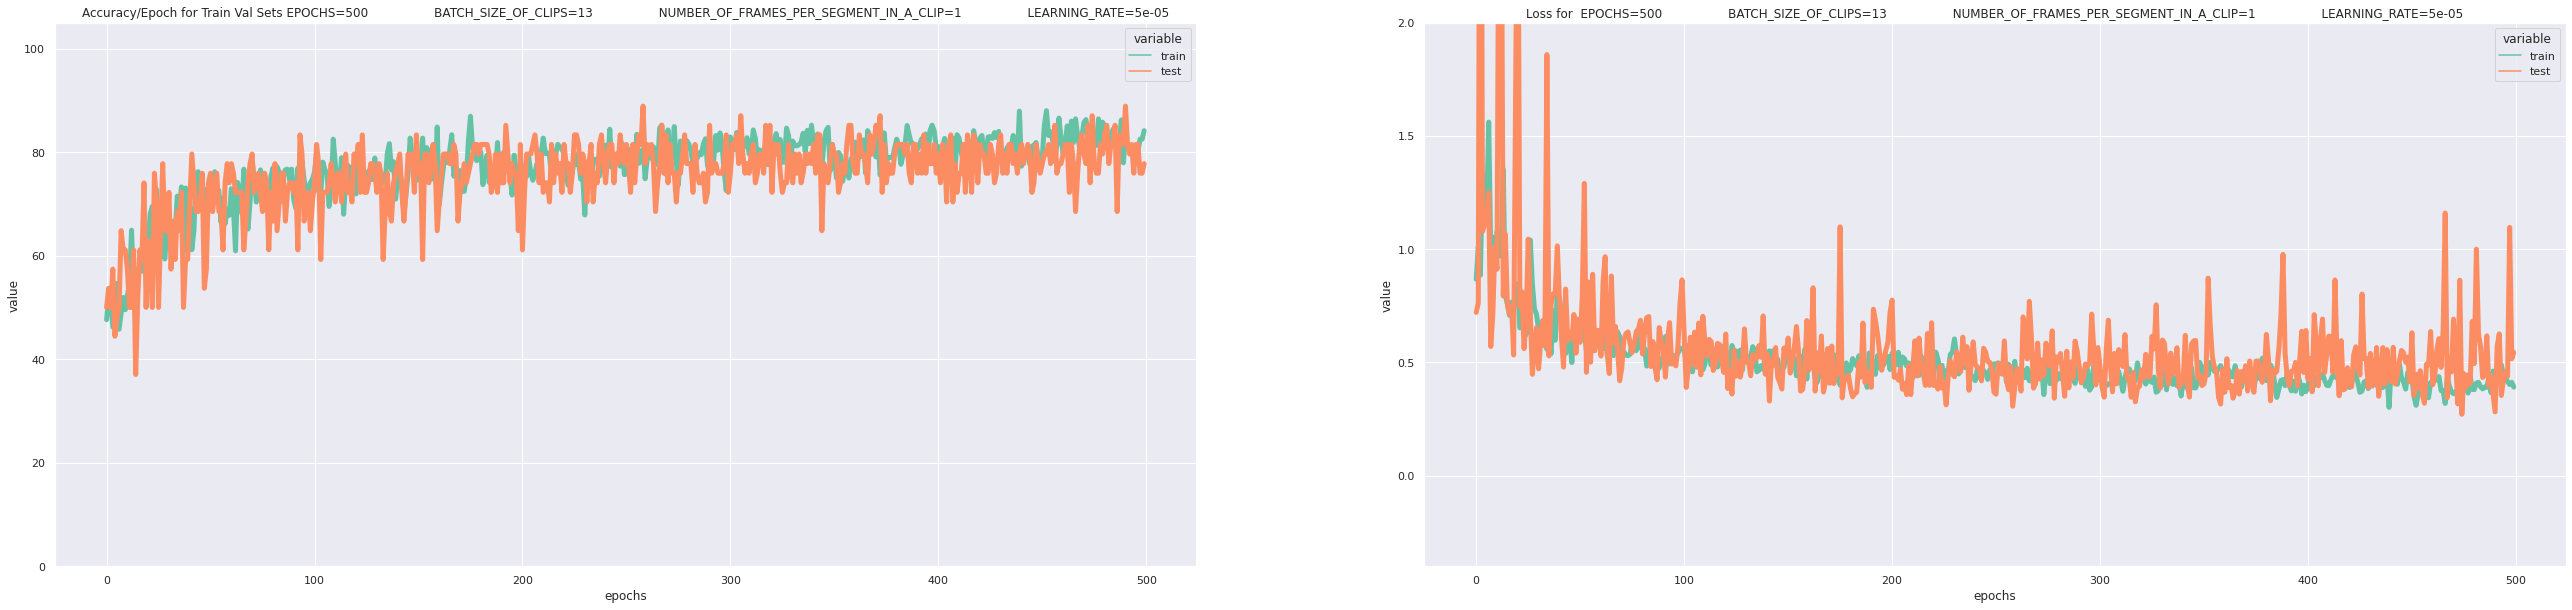

In [14]:
## Convert stats as dataframes
loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
## Concatenate dataframes and dictionaries
loss_df.insert(0, 'curve', 'Loss', True)
acc_df.insert(0, 'curve', 'Acc', True)
valuesall = [loss_df, acc_df]
values_all = pd.concat(valuesall)

all_stats = {
    'ACC': accuracy_stats,
    'LOS': loss_stats,
}


## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)


#################################
#### PLOTING
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,10))
sns.set(style="darkgrid")
sns.lineplot(
    data=acc_df, 
    x = "epochs", y="value", hue="variable",  ax=axes[0],    
    estimator=None, linewidth=5, palette="Set2" 
    ).set_title(f'Accuracy/Epoch for Train Val Sets EPOCHS={MAX_EPOCHS} \
                BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} \
                NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP={NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} \
                LEARNING_RATE={LEARNING_RATE}')

axes[0].set_ylim(0,105)

sns.set(style="darkgrid")
sns.lineplot(
    data=loss_df, 
    x = "epochs", y="value", hue="variable", ax=axes[1],
    estimator=None, linewidth=5, palette="Set2" 
    ).set_title(f'Loss for  EPOCHS={MAX_EPOCHS} \
                BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} \
                NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP={NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} \
                LEARNING_RATE={LEARNING_RATE}')
axes[1].set_ylim(-0.4, 2)



#### PREPARING AND SAVING PERFORMANCE CURVES
WIDTH = 3
PRECISION = 10
TYPE = "f"
STR_LR = f'{LEARNING_RATE:{WIDTH}.{PRECISION}{TYPE}}'
STR_LR = STR_LR.replace(".", "_", 1)

PARAMETERS_FILENAME = "TRAINset_clips_"+ \
                    str(len(train_set))+"TESTset_clips_"+ \
                    str(len(test_set))+"VALset_clips"+ \
                    str(len(validation_dataset))+"___EPOCHS_"+str(f'{MAX_EPOCHS:{WIDTH}}') + \
                    "_BATCH_SIZE_OF_CLIPS_"+str(f'{BATCH_SIZE_OF_CLIPS:02}')+ \
                    "_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_"+ \
                    str(NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP)+"_LEARNING_RATE_"+STR_LR

## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)
TEMP_DICT_TRAINING_CURVES_FOR = "TEMP_DICT_TRAINING_CURVES_FOR____"
IMAGE_FILE_NAME = TEMP_DICT_TRAINING_CURVES_FOR+PARAMETERS_FILENAME
#print(IMAGE_FILE_NAME)
fig.savefig(IMAGE_FILE_NAME) 

## Saving training metrics in dictionaries at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
LOSS_ACC_DICTS_FILE_NAME = "TEMP_DICT_TRAINING_CURVES_FOR____"+"_LOSS_ACC_"+PARAMETERS_FILENAME+'.json'
#print(LOSS_ACC_DICTS_FILE_NAME)
#print(all_stats)

with open(LOSS_ACC_DICTS_FILE_NAME, 'w') as file:
   file.write(json.dumps(all_stats, indent=2))
    


## 11. Evaluate the model on test dataset

In [15]:
model.load_state_dict(torch.load(
    os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth")))
model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for clip_batch_idx, sample_batched in enumerate(test_dataloader):
        X_train_batch, y_train_batch = sample_batched[0].to(DEVICE), sample_batched[1].to(DEVICE)
        print(f'==================================================')
        print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        y_test_pred = model(X_train_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        for i in range(len(y_test_pred)):
            y_true_list.append(y_train_batch[i].cpu().item())
            y_pred_list.append(y_pred_tag[i].cpu().item())
            
        
print(f'==================================================')        
print(f'==================================================')        
print(get_class_distribution(test_set, label_id))
print(f'y_true_list{y_true_list}')
print(f'y_pred_list{y_pred_list}')



 BATCH_OF_CLIPS_INDEX: 0 
   X_train_batch.size(): torch.Size([13, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([13])
 BATCH_OF_CLIPS_INDEX: 1 
   X_train_batch.size(): torch.Size([13, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([13])
 BATCH_OF_CLIPS_INDEX: 2 
   X_train_batch.size(): torch.Size([13, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([13])
 BATCH_OF_CLIPS_INDEX: 3 
   X_train_batch.size(): torch.Size([13, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([13])
 BATCH_OF_CLIPS_INDEX: 4 
   X_train_batch.size(): torch.Size([13, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([13])
 BATCH_OF_CLIPS_INDEX: 5 
   X_train_batch.size(): torch.Size([9, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([9])
{'BKGR': 37, '4CV': 37}
y_true_list[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 

              precision    recall  f1-score   support

           0       0.78      0.76      0.77        37
           1       0.76      0.78      0.77        37

    accuracy                           0.77        74
   macro avg       0.77      0.77      0.77        74
weighted avg       0.77      0.77      0.77        74

                    Precision    Recall  F1-score  Support
0                    0.777778  0.756757  0.767123     37.0
1                    0.763158  0.783784  0.773333     37.0
weighted avg/Total   0.770468  0.770270  0.770228      NaN
Avg/Total                 NaN       NaN       NaN     74.0
[[28  9]
 [ 8 29]]


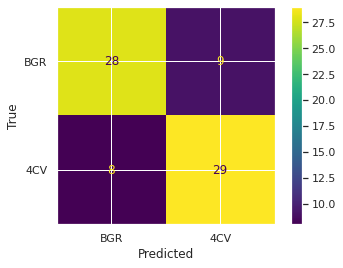

In [16]:
report = classification_report(y_true_list, y_pred_list)
print(report)
# report_support = precision_recall_fscore_support(y_true_list, y_pred_list)
# print(report_support)

def metrics_report_to_df(ytrue, ypred):
    classification_report_df = pd.DataFrame(data=list(precision_recall_fscore_support(y_true_list, y_pred_list)), \
                                         index=['Precision', 'Recall', 'F1-score', 'Support']).T    
    classification_report_df.loc['weighted avg/Total', :] = precision_recall_fscore_support(ytrue, ypred, average='weighted')
    classification_report_df.loc['Avg/Total', 'Support'] = classification_report_df['Support'].sum()
    return(classification_report_df)

classification_report_df = metrics_report_to_df(y_true_list, y_pred_list)
print(classification_report_df)


# print(confusion_matrix(y_true_list, y_pred_list))
#################################
### PLOTTING CONFUSION MATRIX
cm=confusion_matrix(y_true_list, y_pred_list)
print(cm)
#cm=confusion_matrix(y_true_list, y_pred_list, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['BGR','4CV'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')


#### PREPARING AND SAVING TRAINING PERFORMANCE PARAMETERS
train_values = {} # instantiate an empty train_values dict 
train_values['elapsed_time_in_secs'] = elapsed_time
train_values['MAX_EPOCHS'] = MAX_EPOCHS
train_values['LEARNING_RATE'] = LEARNING_RATE
train_values['BATCH_SIZE_OF_CLIPS'] = BATCH_SIZE_OF_CLIPS
train_values['PRETRANSFORM_IM_SIZE'] = PRETRANSFORM_IM_SIZE
train_values['FRAMES_PER_CLIP'] = NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP
train_values['Train Dataset Size'] = len(train_set)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Test Dataset Size'] = len(test_set)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Validation Dataset Size'] = len(validation_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Current date and time'] = datetime.now().strftime('%dD-%mM-%yY_%HH-%MM-%SS')
#team['konqi'] = {'health': 18, 'level': 7}

## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)
TRAIN_FILE_NAME = TEMP_DICT_TRAINING_CURVES_FOR+"TRAINING_PARAMETERS"+PARAMETERS_FILENAME+".json"


with open(TRAIN_FILE_NAME, 'w') as file:
     file.write(json.dumps(train_values, indent=4))

        


## 12. [**!WARNING!**] Cleanup temporal data directory 
Remove directory if a temporary was used.

```
       Make sure you know which path you will remove as you do not like to remove important files.
       shutil.rmtree
```

In [ ]:
temporal_files_path = config['temporal_data_path']

shutil.rmtree(temporal_files_path)
print(f' {temporal_files_path} is empty')